### Converting from a flow law to inputs in aspect

The difference between a flow law and the form of rheology used in aspect's visco-plastic module is:

Form of the flow law:

$\eta_{df, ds} = F \left(\frac{d^p}{A C^r_{OH}} \right)^{\frac{1}{n}}\dot{\epsilon_E}^{\frac{1-n}{n}}exp\left(\frac{E+P_{lc}V}{nRT}\right)$

Here F is a effective coefficient to account for the differences in the conditions in experiments.

Rheology module in aspect:

$\eta_{df, ds} = 0.5 A_p^{-1/n} d^{\frac{m}{n}} \dot{\epsilon_E}^{\frac{1-n}{n}} exp\left(\frac{E+PV}{nRT}\right) $

The main difference in equation is a 0.5 in aspect's rheology and a F in an effective flow law.
Otherwise, We use U/I unit in aspect, so d is given in m. In a flow law, d is given in $\mu m $
All these differences will be incorporated into the prefactor A.

$ A_p = {10}^{-6p} {10}^{-6n} {C_{oh}}^r A / F^n $


In [38]:
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib import gridspec

In [39]:
# dislocation creep in Hirth & Kohlstedt 2003
HK03_disl = \
    {
        "A": 90,
        "p": 0.0,
        "r": 1.2,
        "n": 3.5,
        "E": 480e3,
        "V": 11e-6,
        "d" : 1e4,
        "Coh" : 1000.0
    }

# diffusion creep in Hirth & Kohlstedt 2003
HK03_diff = \
    {
        "A" : 1.0e6,
        "p" : 3.0,
        "r" : 1.0,
        "n" : 1.0,
        "E" : 335e3,
        "V" : 4e-6,
        "d" : 1e4,
        "Coh" : 1000.0
    }

# modified creep laws from Hirth & Kohlstedt 2003
# for detail, refer to magali's explain_update_modHK03_rheology.pdf file
HK03_wet_mod_diff = \
    {
        # "A" : 10**6.9,  # MPa^(-n-r)*um**p/s
        "A" : 7.1768e6,  # MPa^(-n-r)*um**p/s
        "p" : 3.0,
        "r" : 1.0,
        "n" : 1.0,
        "E" : 375e3,
        "V" : 23e-6,
        "d" : 1e4,
        "Coh" : 1000.0,
        "wet": 1.0  # I use this to mark this is a wet rheology, so I need to account for V and E for water later.
    }

HK03_wet_mod_disl = \
    {
        "A" : 10**2.65,
        "p" : 0.0,
        "r" : 1.0,
        "n" : 3.5,
        "E" : 520e3,
        "V" : 24e-6,
        "d" : 1e4,
        "Coh" : 1000.0,
        "wet" : 1.0
    }

def Convert2AspectInput(creep_type, **kwargs):
    """
    Viscosity is calculated by flow law in form of (strain_rate)**(1.0 / n - 1) * (B)**(-1.0 / n) * np.exp((E + P * V) / (n * R * T)) * 1e6
    while in aspect, flow law in form of 0.5 * A**(-1.0 / n) * d**(m / n) * (strain_rate)**(1.0 / n - 1) * np.exp((E + P * V) / (n * R * T))
    Original Units:
     - P: Pa
     - T: K
     - d: mm
     - Coh: H / 10^6 Si
    Original Units:
     - P: Pa
     - T: K
     - d: m
    """
    # read in initial value
    A = creep_type['A']
    p = creep_type['p']
    r = creep_type['r']
    n = creep_type['n']
    E = creep_type['E']
    V = creep_type['V']
    d = creep_type['d']
    Coh = creep_type['Coh']
    # compute value of F(pre factor)
    use_effective_strain_rate = kwargs.get('use_effective_strain_rate', False)
    if use_effective_strain_rate:
        F = 1 / (2**((n-1)/n)*3**((n+2)/2/n))
    else:
        F = 1.0
    # prepare values for aspect
    aspect_creep_type = {}
    # stress in the original equation is in Mpa, grain size is in um
    aspect_creep_type['A'] = 1e6**(-p) * (1e6)**(-n) * Coh**r * A / F**n  # F term: use effective strain rate
    aspect_creep_type['d'] = d / 1e6
    aspect_creep_type['n'] = n
    aspect_creep_type['m'] = p
    aspect_creep_type['E'] = E
    aspect_creep_type['V'] = V
    return aspect_creep_type

#### Convert to aspect outputs

In this part, the Convering function is called to transfer to an input in aspect.

Then, I output the entries for the prm file accordingly.
In aspect, we set the parameters with in a "material model".
Here we output the entries for this "material model".
For example, these outputs could be included in the "Visco Plastic" module

In [40]:
HK03_diff_aspect = Convert2AspectInput(HK03_diff)
HK03_disl_aspect = Convert2AspectInput(HK03_disl)
outputs = ""
outputs += "set Viscous flow law = composite\n"
outputs += "set Prefactors for diffusion creep = %.4e\n" % HK03_diff_aspect['A']
outputs += "set Grain size exponents for diffusion creep = %.4e\n" % HK03_diff_aspect['m']
outputs += "set Activation energies for diffusion creep = %.4e\n" % HK03_diff_aspect['E']
outputs += "set Activation volumes for diffusion creep = %.4e\n" % HK03_diff_aspect['V']
outputs += "set Prefactors for dislocation creep = %.4e\n" % HK03_disl_aspect['A']
outputs += "set Stress exponents for dislocation creep = %.4e\n" % HK03_disl_aspect['n']
outputs += "set Activation energies for dislocation creep  = %.4e\n" % HK03_disl_aspect['E']
outputs += "set Activation volumes for dislocation creep  = %.4e\n" % HK03_disl_aspect['V']
print(outputs)

set Viscous flow law = composite
set Prefactors for diffusion creep = 1.0000e-15
set Grain size exponents for diffusion creep = 3.0000e+00
set Activation energies for diffusion creep = 3.3500e+05
set Activation volumes for diffusion creep = 4.0000e-06
set Prefactors for dislocation creep = 3.5830e-16
set Stress exponents for dislocation creep = 3.5000e+00
set Activation energies for dislocation creep  = 4.8000e+05
set Activation volumes for dislocation creep  = 1.1000e-05



#### Step 2 Include a lower mantle rheology with a jump at the boundary

Firstly, we need two functions to compute pressure and temperature at 660 km depth.

Secondly, we will take the diffusion creep rheology in the upper mantle, compute the viscosity at 660km.
Last, a jump is applied on the lower mantle rheology right at 660km depth by altering the value of A.
Note that an activation volume is prescribed, due to the lack of knowledge on the lower mantle rheology.
We will discuss the choice of that in the next section.

With this, we will explain how the parameter file handles this new rheology by using a phase transition function

In [41]:
def adiabatT(zs):
    '''
    compute adiabatic temperature based on depth
    Inputs:
    z (float or ndarray) - depth (m)
    '''
    Tad_surface = 1673.0 
    mad = 0.5715  # deg/km, approximating adiabat to match T(CMB) in Aspect
    Tads = Tad_surface + mad*(zs/1e3)
    return Tads

def pressure_from_lithostatic(z,Tad):
    '''
    A lithostatic pressure profile
    Inputs:
	z (float) - depth in m
	Tad (float) - adiabatic temperature
    '''
    # Density Profile
    refrho = 3300  # kg/m^3
    refT = 1673        # K
    alpha = 3.1e-5  # 1/K
    g = 9.81 # m/s^2
    density = refrho*(1-alpha*(Tad-refT))

    # start loop at 1 because P[0] = 0
    dz = z[1]-z[0]
    P = np.zeros(np.size(z))
    for i in range(1, np.size(z)):
        P[i] = P[i-1] + 0.5*(density[i]+density[i-1])*g*dz
    return P

Here, we use the phase function entries in the "Visco plastic" material model.
Phase transition are set up by:
        
	set Phase transition depths = background:660e3
        set Phase transition widths = background:5e3
        set Phase transition temperatures = background:1673.0
        set Phase transition Clapeyron slopes = background:-2e6

Here "background" indicates we are assigning properties to the "background" composition.
As for the properties, an example is:

	set Prefactors for diffusion creep = background: 1.0000e-15| 3.3333e-17

The "|" connects two entries for two phases, respectively.

The follow section would output the settings in the prm file for the lower mantle rheology.
Note that for the dislocation creep, we simply set the A value to be the limit of float32 value, so it wont' be activated.

In [42]:
jump = 30.0  # jump of viscosity at the upper / lower mantle boundary
R = 8.314
lm_diff_aspect = HK03_diff_aspect.copy()
# prescribe upper mantle parameters
A = HK03_diff_aspect['A']
n = HK03_diff_aspect['n']
V = HK03_diff_aspect['V']
T = adiabatT(660e3)
zs = np.linspace(0, 1000e3, 1001) # to compute P, we need an array of increment of depth
Tads = adiabatT(zs)
Ps = pressure_from_lithostatic(zs, Tads)
P = Ps[660]
# prescribe lower mantle activation volume, with P and T at 660 km depth
V1 = 4e-6
lm_diff_aspect['A'] = jump**(-n) * A * np.exp(P * (V1 - V) / (R * T))
# outputs
outputs = ""
outputs += "set Viscous flow law = composite\n"
outputs += "set Prefactors for diffusion creep = background: %.4e| %.4e\n" % (HK03_diff_aspect['A'], lm_diff_aspect['A'])
outputs += "set Grain size exponents for diffusion creep = background: %.4e| %.4e\n" % (HK03_diff_aspect['m'], lm_diff_aspect['m'])
outputs += "set Activation energies for diffusion creep = background: %.4e| %.4e\n" % (HK03_diff_aspect['E'], lm_diff_aspect['E'])
outputs += "set Activation volumes for diffusion creep = background: %.4e| %.4e\n" % (HK03_diff_aspect['V'], lm_diff_aspect['V'])
outputs += "set Prefactors for dislocation creep = background: %.4e| %.4e\n" % (HK03_disl_aspect['A'], 5e-32)
outputs += "set Stress exponents for dislocation creep = background: %.4e| %.4e\n" % (HK03_disl_aspect['n'],  HK03_disl_aspect['n'])
outputs += "set Activation energies for dislocation creep  = background: %.4e| %.4e\n" % (HK03_disl_aspect['E'], HK03_disl_aspect['E'])
outputs += "set Activation volumes for dislocation creep  = background: %.4e| %.4e\n" % (HK03_disl_aspect['V'], HK03_disl_aspect['V'])
print(outputs)

set Viscous flow law = composite
set Prefactors for diffusion creep = background: 1.0000e-15| 3.3333e-17
set Grain size exponents for diffusion creep = background: 3.0000e+00| 3.0000e+00
set Activation energies for diffusion creep = background: 3.3500e+05| 3.3500e+05
set Activation volumes for diffusion creep = background: 4.0000e-06| 4.0000e-06
set Prefactors for dislocation creep = background: 3.5830e-16| 5.0000e-32
set Stress exponents for dislocation creep = background: 3.5000e+00| 3.5000e+00
set Activation energies for dislocation creep  = background: 4.8000e+05| 4.8000e+05
set Activation volumes for dislocation creep  = background: 1.1000e-05| 1.1000e-05



(todo)
Next we plot the viscosity profile in aspect.
We will first read in the computed temperature & pressure profile from the "depth_average.txt" file.

For the lower mantle, note that the rheology has a large uncertainty, thus we could adjust the values by looking at the profile.

(todo)
Why we cannot just assign a constant viscosity for the lower mantle?


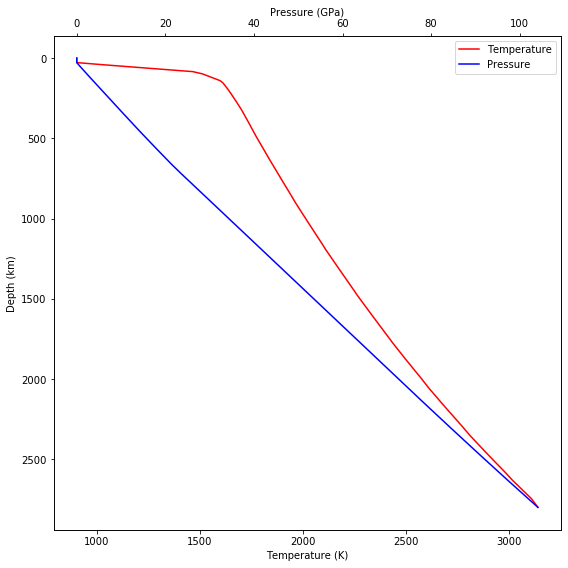

In [52]:
# (todo) Read a temperature profile from aspect
depth_avg_file="./depth_average.txt"
assert(os.path.isfile(depth_avg_file))
data = np.genfromtxt(depth_avg_file, comments='#', filling_values=0.0)
zs = data[:, 1]
Ts = data[:, 2]
Ps = data[:, 8]
# interpolate to more points
zNs = np.linspace(0, 2800e3, 200)
TNs = np.interp(zNs, zs, Ts)
PNs = np.interp(zNs, zs, Ps)
# Plot the profile
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(2, 2)
ax = fig.add_subplot(gs[0, 0]) # plot temperature & pressure
lns1 = ax.plot(TNs, zNs/1e3, 'r-', label = "Temperature")  
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Depth (km)")
ax.invert_yaxis()
ax_p = ax.twiny()
lns2 = ax_p.plot(PNs/1e9, zNs/1e3, 'b-', label = "Pressure")
ax_p.set_xlabel("Pressure (GPa)")
lns = lns1 + lns2
labs = [I.get_label() for I in lns]
ax.legend(lns, labs)